<a href="https://colab.research.google.com/github/austinlasseter/DS-Unit-2-Applied-Modeling/blob/master/module4-model-interpretation/2_3_4_Canvas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. visualize and interpret partial dependence plots

## Overview
In this sprint, and the unit overall, we have been focusing on the feature importance as determined by simply ranking them. We've looked at lists of features and their contribution to the model. But sometimes, we want more information about how the model is working and how a specific feature(s) affects the model predictions. One of the main way to take a look inside a "black box" model is to utilize partial dependence plots.

A partial dependence plot can be used to show how a model prediction partially depends on values of the input variables of interest (the input feature). For example, in the data we'll explore below, we can fit a model to predict wine quality. Once we have the model fit, we can isolate a particular feature and visualize how the model prediction depends on that feature over its range of values. The plots below will show how we visualize the model prediction's dependence on alcohol content.

## Follow Along
We're back to the wine quality data set. In this example, we're going to change our target to having only two classes (bad/good): 0 for quality less than or equal to 5 and 1 for above five. Rethinking this problem as a binary classification will make it easier to visualize our partial dependence plots because the model itself will be simpler.

After loading in the data, we'll fir a simple decision tree classifier model. We're not going to split the data into training and testing sets because we're not looking at the accuracy or other evaluation metrics right now. So we'll use all of the data to train the model and to create the partial dependence plots.

In [3]:
# Load the dataset
import pandas as pd
url = 'https://raw.githubusercontent.com/austinlasseter/data-science-curriculum/main/Unit%202%20-%20Predictive%20Modeling/Sprint%203%20-%20Applied%20Modeling/Module%204%20-%20Model%20Interpretation/notebooks/winequality-red.csv?token=AHQLQMCSVSV4ZS7TFMMXHLK7Q6H4A'
wine = pd.read_csv(url, sep=';')
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
# Set the features list and target variable 
target = 'quality'
X = wine.drop(target, axis=1)

# Create the target array
y = wine['quality']

# Map the target to a binary class at quality = 5
y = y.apply(lambda x: 0 if x <= 5 else 1)

# Instantiate the classifier
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=42)

wine_model = clf.fit(X, y)

## Calculating the Partial Dependence
We always calculate our partial dependence values after we have fit a model. Using the plot_partial_dependence() module, we specify the features that we would like to visualize. In this case, the alcohol and chlorides are the two features we're using. Usually, you would have analyzed the feature importances and then selected the most important features. In this case, we're using a slightly different red wine data set than what is available from the scikit-learn datasets module, but alcohol is one of the top features in importance.

In [5]:
from sklearn.inspection import plot_partial_dependence
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(12,4))
plot_partial_dependence(wine_model, feature_names=X.columns, 
                        features=['alcohol','chlorides'], 
                        X=X, grid_resolution=50, ax=ax);

ax.set_title('Wine: Partial Dependence')

#plt.show()

plt.clf()

<Figure size 864x288 with 0 Axes>

On the left plot, we can see as the percentage of alcohol increases, the model more strongly predicts higher quality. On the right, the amount of chlorides in the wine doesn't seem to affect the prediction as much as the alcohol content feature.

Now, we're going to use a different library to visualize the partial dependence for one feature. This plot is calculating the same dependence of the feature but is plotting all of the predictions (shaded area) as well as the average (solid line).

In [7]:
! pip install pdpbox

     |████████████████████████████████| 57.7MB 74kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690724 sha256=c049e3228dd921bee017b1e135c7aad743c6b7eb0c4bbed26578a60d82bc8e5e
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


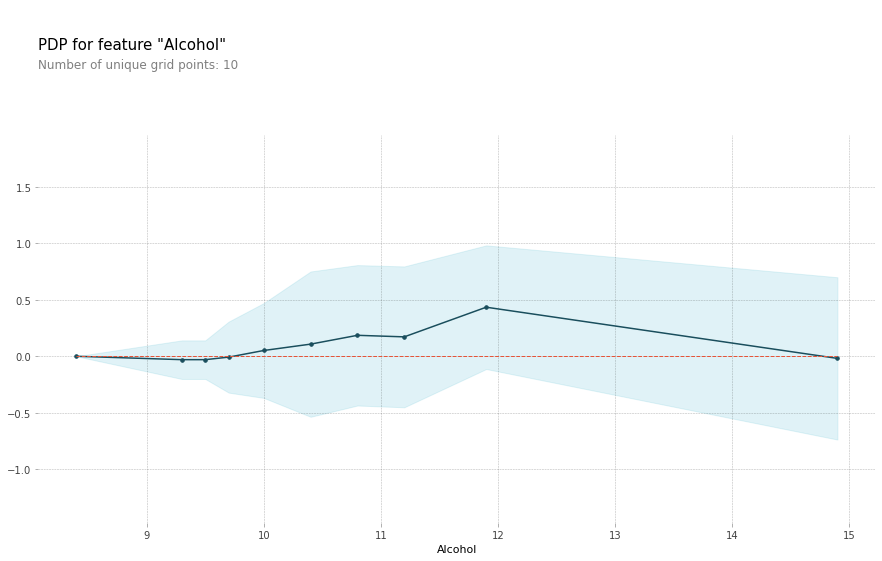

In [10]:
from pdpbox.pdp import pdp_isolate, pdp_plot

# Create the plot for a single feature isolated

isolated = pdp_isolate(
    model= wine_model,
    dataset=X,
    model_features=X.columns,
    feature='alcohol'
)

pdp_plot(isolated, feature_name='Alcohol');

# plt.clf()
plt.show()

# 2. explain individual predictions with shapley value plots

## Overview
In this objective, we'll dive a little deeper into how individual features contribute to making a prediction. A quantity called a Shapley value borrows from game theory concepts to try to explain the difference between the prediction of an individual observation compared to the average prediction from all the observations (instances).

One way to consider this problem is to think of the features in the model working together to make a prediction. For example, using the wine data set from the previous objective, we can consider the alcohol content, the sulphates, and the pH. For one observation (row of the DataFrame), they work together to make a prediction. The rest of the rows all work together to make the average prediction. The Shapley values look at each feature's contribution to the single row prediction and explain exactly how it make it different from the average prediction.

Let' work through an example using the SHAP library which stands for SHapley Additive exPlanations.

In [12]:
# Load the dataset
import pandas as pd
wine = pd.read_csv(url, sep=';')
wine.head()

# Set the features list and target variable 
target = 'quality'
X = wine.drop(target, axis=1)

# Create the target array
y = wine['quality']

# Map the target to a binary class at quality = 5
y = y.apply(lambda x: 0 if x <= 5 else 1)

To calculate the Shapley values, we'll be fitting a xgboost classifier model to the data. The TreeExplainer() is used to explain the output of ensemble tree models. From the explainer values, we calculate the Shapley values and then visualize the results for a single observation (instance).

In [14]:
! pip install shap

     |████████████████████████████████| 327kB 2.7MB/s 
  Created wheel for shap: filename=shap-0.36.0-cp36-cp36m-linux_x86_64.whl size=456469 sha256=04d23d03c96ca6e85876ad145d97fb7388fc08dffe536c2f0e70572510d4150e
  Stored in directory: /root/.cache/pip/wheels/fb/15/e1/8f61106790da27e0765aaa6e664550ca2c50ea339099e799f4
Successfully built shap


In [16]:
# Import shap
import shap

# Instantiate and fit the model
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=42)
wine_model = xgb.fit(X, y)
mybooster = wine_model.get_booster()

# The following code correction for an encoding error
model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
mybooster.save_raw = myfun

In [17]:
# Shap explainer initilization
shap_ex = shap.TreeExplainer(mybooster)

UnicodeDecodeError: ignored

In [21]:

# Calculate the shapley values
shap_values = shap_ex.shap_values(X)

# Initialize the plot
shap.initjs()

# Plot the values for the 25th row of the 
shap.force_plot(shap_ex.expected_value, shap_values[25,:], X.iloc[25,:])

plt.show()


NameError: ignored

We can interpret the above plot in the following way: the value for volatile acidity was more important in predicting wine quality. The alcohol content and residual sugar (and others) were less important in predicting the wine quality.

